### SIFT with FLANN Based Matcher with Lowe's ratio test, with and without RANSAC for an occluded object


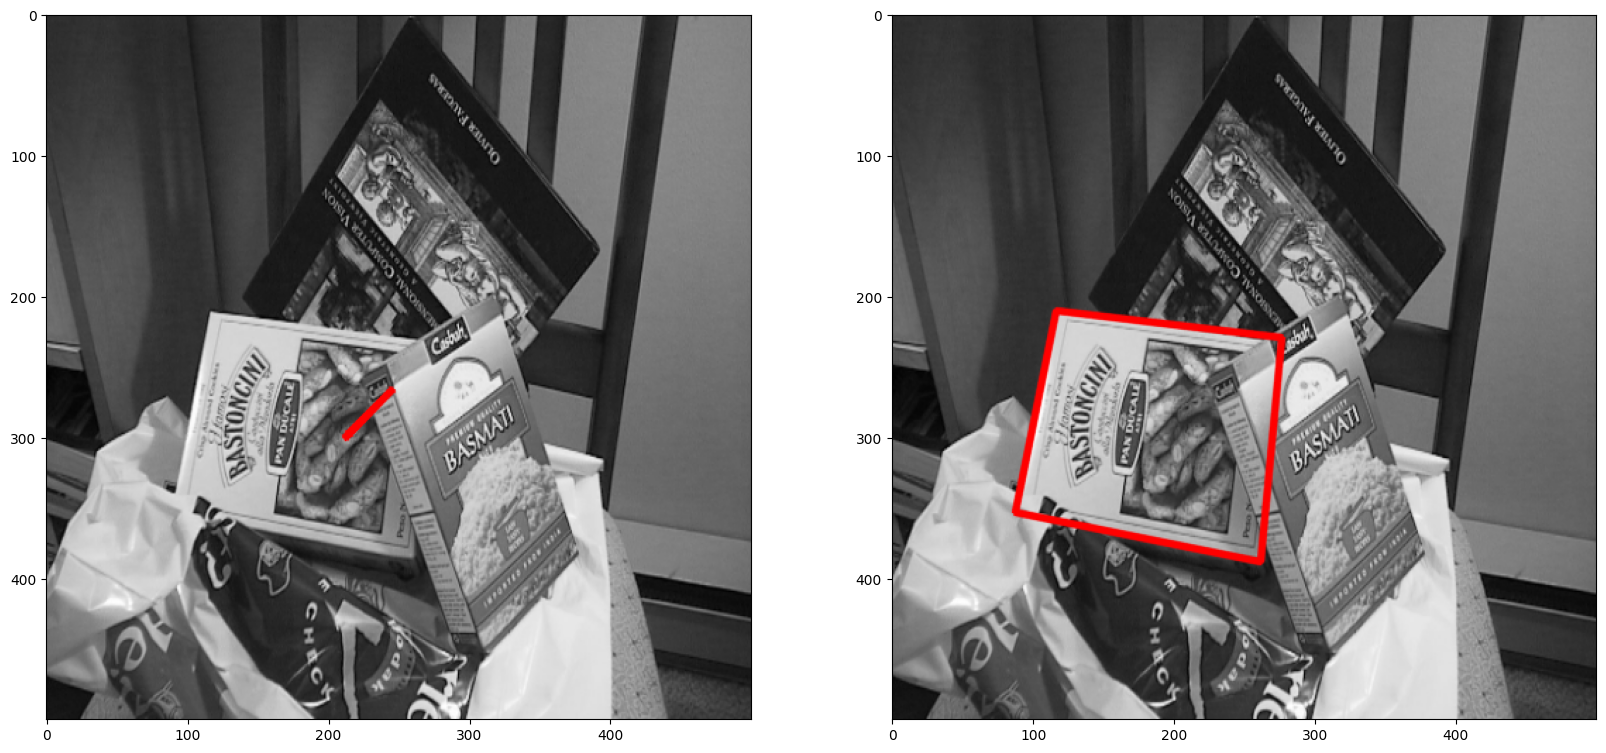

In [24]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

IMAGE_PATH_SCENE = "./images/matches_scene.png"
IMAGE_PATH_OBJECT = "./images/matches_obj.png"

file_name_cards = IMAGE_PATH_SCENE.rsplit("/", maxsplit=1)[-1]
file_name_object = IMAGE_PATH_OBJECT.rsplit("/", maxsplit=1)[-1]

img_cards = cv2.imread(IMAGE_PATH_SCENE)
img_object = cv2.imread(IMAGE_PATH_OBJECT)

dsize = (500, 500)
dsize2 = (200, 300)

output_cards = cv2.resize(img_cards, dsize)
output_cards_r = cv2.resize(img_cards, dsize)

output_obj = cv2.resize(img_object, dsize2)

object_gray = cv2.cvtColor(output_obj, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(output_cards, cv2.COLOR_BGR2GRAY)

# Correctly identified the object in the scene image (probably because SIFT is invariant to scale, rotation, and affine distortion and the card is rotated)
detector = cv2.SIFT_create()

object_kp, object_des = detector.detectAndCompute(object_gray, None)
scene_kp, scene_des = detector.detectAndCompute(scene_gray, None)


FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
matcher = cv2.FlannBasedMatcher(index_params, search_params)
ratio = 0.9
matches = matcher.knnMatch(object_des, scene_des, k=2)
good_matches = []
for m, n in matches:
    if m.distance < ratio * n.distance:
        good_matches.append(m)
        



src_pts = np.float32([object_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts, 0, 5.0)
H_r, mask_r = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


h, w = output_obj.shape[:2]
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, H)
scene_img = cv2.polylines(output_cards, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

h_r, w_r = output_obj.shape[:2]
pts_r = np.float32([[0, 0], [0, h_r - 1], [w_r - 1, h_r - 1], [w_r - 1, 0]]).reshape(-1, 1, 2)
dst_r = cv2.perspectiveTransform(pts_r, H_r)
scene_img_r = cv2.polylines(output_cards_r, [np.int32(dst_r)], True, 255, 3, cv2.LINE_AA)


cv2.imshow('Result', scene_img_r)
cv2.waitKey(0)

cv2.destroyAllWindows()

line_images = [scene_img,scene_img_r]
_, axs = plt.subplots(1, 2, figsize=(20,20))
axs = axs.flatten()
for img, ax in zip(line_images, axs):
    ax.imshow(img)



### SIFT with FLANN Based Matcher with Lowe's ratio test, with and without RANSAC for a non-plannar object


<function matplotlib.pyplot.show(close=None, block=None)>

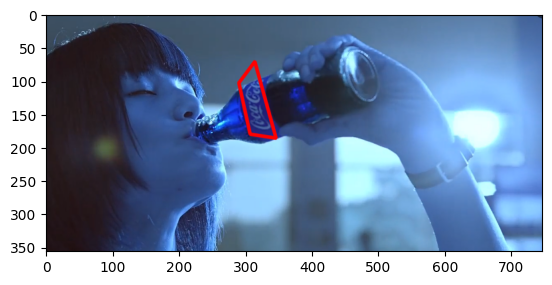

In [10]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
#Step 1: Detect the keypoints using SIFT Detector, compute the descriptors
IMAGE_PATH_SCENE = "./images/cola_scene.png"
IMAGE_PATH_OBJECT = "./images/cola_logo.png"

file_name_cards = IMAGE_PATH_SCENE.rsplit("/", maxsplit=1)[-1]
file_name_object = IMAGE_PATH_OBJECT.rsplit("/", maxsplit=1)[-1]

img_scene = cv2.imread(IMAGE_PATH_SCENE)
img_object = cv2.imread(IMAGE_PATH_OBJECT)

sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
keypoints_obj, descriptors_obj = sift.detectAndCompute(img_object,None)
keypoints_scene, descriptors_scene = sift.detectAndCompute(img_scene,None)


#Step 2: Matching descriptor vectors with a FLANN based matcher
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(descriptors_obj, descriptors_scene, 2)
#-- Filter matches using the Lowe's ratio test
ratio_thresh = 0.75
good_matches = []
for m,n in knn_matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)


#Step 3: Localize the object
obj = np.empty((len(good_matches),2), dtype=np.float32)
scene = np.empty((len(good_matches),2), dtype=np.float32)

for i in range(len(good_matches)):
    #-- Get the keypoints from the good matches
    obj[i,0] = keypoints_obj[good_matches[i].queryIdx].pt[0]
    obj[i,1] = keypoints_obj[good_matches[i].queryIdx].pt[1]
    scene[i,0] = keypoints_scene[good_matches[i].trainIdx].pt[0]
    scene[i,1] = keypoints_scene[good_matches[i].trainIdx].pt[1]

H, _ =  cv2.findHomography(obj, scene, cv2.RANSAC) # ---- RANSAC


h_r, w_r = img_object.shape[:2]
pts_r = np.float32([[0, 0], [0, h_r - 1], [w_r - 1, h_r - 1], [w_r - 1, 0]]).reshape(-1, 1, 2)
dst_r = cv2.perspectiveTransform(pts_r, H)
scene_img_r = cv2.polylines(img_scene, [np.int32(dst_r)], True, 255, 3, cv2.LINE_AA)


cv2.imshow('Result', scene_img_r)
cv2.waitKey(0)

cv2.destroyAllWindows()

plt.imshow(scene_img_r)
plt.show



### SIFT with FLANN Based Matcher with Lowe's ratio test, with and without RANSAC for a non occluded object


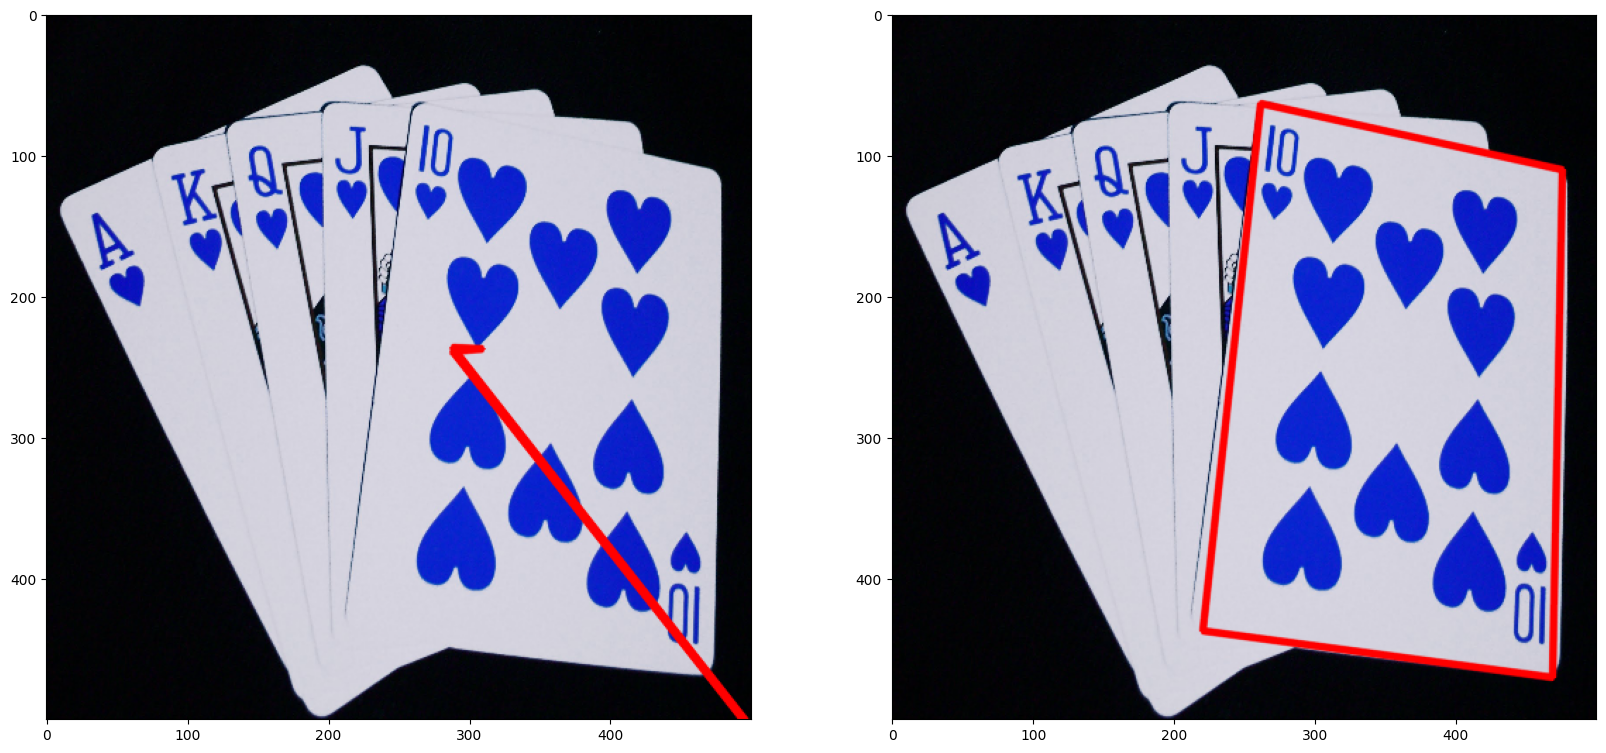

In [3]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

IMAGE_PATH_SCENE = "./images/cards.jpg"
IMAGE_PATH_OBJECT = "./images/cards_object.png"

file_name_cards = IMAGE_PATH_SCENE.rsplit("/", maxsplit=1)[-1]
file_name_object = IMAGE_PATH_OBJECT.rsplit("/", maxsplit=1)[-1]

img_cards = cv2.imread(IMAGE_PATH_SCENE)
img_object = cv2.imread(IMAGE_PATH_OBJECT)

dsize = (500, 500)
dsize2 = (200, 300)

output_cards = cv2.resize(img_cards, dsize)
output_cards_r = cv2.resize(img_cards, dsize)

output_obj = cv2.resize(img_object, dsize2)

object_gray = cv2.cvtColor(output_obj, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(output_cards, cv2.COLOR_BGR2GRAY)

# Correctly identified the object in the scene image (probably because SIFT is invariant to scale, rotation, and affine distortion and the card is rotated)
detector = cv2.SIFT_create()

object_kp, object_des = detector.detectAndCompute(object_gray, None)
scene_kp, scene_des = detector.detectAndCompute(scene_gray, None)


FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
matcher = cv2.FlannBasedMatcher(index_params, search_params)
ratio = 0.8
matches = matcher.knnMatch(object_des, scene_des, k=2)
good_matches = []
for m, n in matches:
    if m.distance < ratio * n.distance:
        good_matches.append(m)
        



src_pts = np.float32([object_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts, 0, 5.0)
H_r, mask_r = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


h, w = output_obj.shape[:2]
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, H)
scene_img = cv2.polylines(output_cards, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

h_r, w_r = output_obj.shape[:2]
pts_r = np.float32([[0, 0], [0, h_r - 1], [w_r - 1, h_r - 1], [w_r - 1, 0]]).reshape(-1, 1, 2)
dst_r = cv2.perspectiveTransform(pts_r, H_r)
scene_img_r = cv2.polylines(output_cards_r, [np.int32(dst_r)], True, 255, 3, cv2.LINE_AA)


cv2.imshow('Result', scene_img_r)
cv2.waitKey(0)

cv2.destroyAllWindows()

line_images = [scene_img,scene_img_r]
_, axs = plt.subplots(1, 2, figsize=(20,20))
axs = axs.flatten()
for img, ax in zip(line_images, axs):
    ax.imshow(img)


## SIFT with Brute force matcher with Lowe's ratio test with and without RANSAC for an occluded object

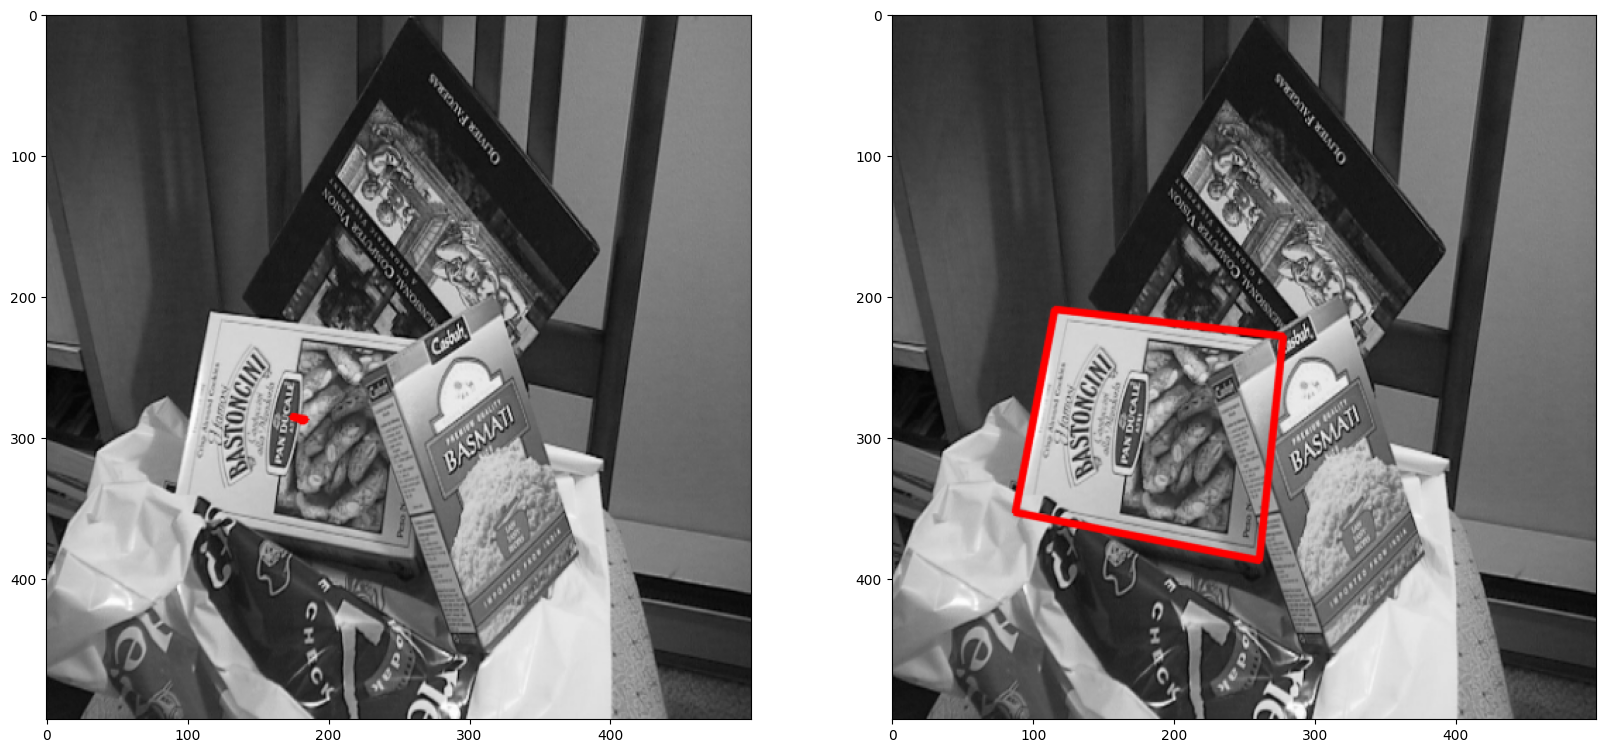

In [4]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

# Image of the plane
IMAGE_PATH_SCENE = "./images/matches_scene.png"
IMAGE_PATH_OBJECT = "./images/matches_obj.png"

file_name_cards = IMAGE_PATH_SCENE.rsplit("/", maxsplit=1)[-1]
file_name_object = IMAGE_PATH_OBJECT.rsplit("/", maxsplit=1)[-1]

img_cards = cv2.imread(IMAGE_PATH_SCENE)
img_object = cv2.imread(IMAGE_PATH_OBJECT)

dsize = (500, 500)
dsize2 = (200, 300)

output_cards = cv2.resize(img_cards, dsize)
output_cards_r = cv2.resize(img_cards, dsize)

output_obj = cv2.resize(img_object, dsize2)

object_gray = cv2.cvtColor(output_obj, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(output_cards, cv2.COLOR_BGR2GRAY)

# Correctly identified the object in the scene image (probably because SIFT is invariant to scale, rotation, and affine distortion and the card is rotated)
detector = cv2.SIFT_create()

object_kp, object_des = detector.detectAndCompute(object_gray, None)
scene_kp, scene_des = detector.detectAndCompute(scene_gray, None)


matcher = cv2.BFMatcher()
matches = matcher.knnMatch(object_des, scene_des, k=2)

good_matches = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good_matches.append(m)



src_pts = np.float32([object_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts, 0, 5.0)
H_r, mask_r = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


h, w = output_obj.shape[:2]
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, H)
scene_img = cv2.polylines(output_cards, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

h_r, w_r = output_obj.shape[:2]
pts_r = np.float32([[0, 0], [0, h_r - 1], [w_r - 1, h_r - 1], [w_r - 1, 0]]).reshape(-1, 1, 2)
dst_r = cv2.perspectiveTransform(pts_r, H_r)
scene_img_r = cv2.polylines(output_cards_r, [np.int32(dst_r)], True, 255, 3, cv2.LINE_AA)


cv2.imshow('Result', scene_img_r)
cv2.waitKey(0)

cv2.destroyAllWindows()

line_images = [scene_img,scene_img_r]
_, axs = plt.subplots(1, 2, figsize=(20,20))
axs = axs.flatten()
for img, ax in zip(line_images, axs):
    ax.imshow(img)



## Orb with FLann's based matcher with Lowe's ratio test with and without RANSAC for an occluded object

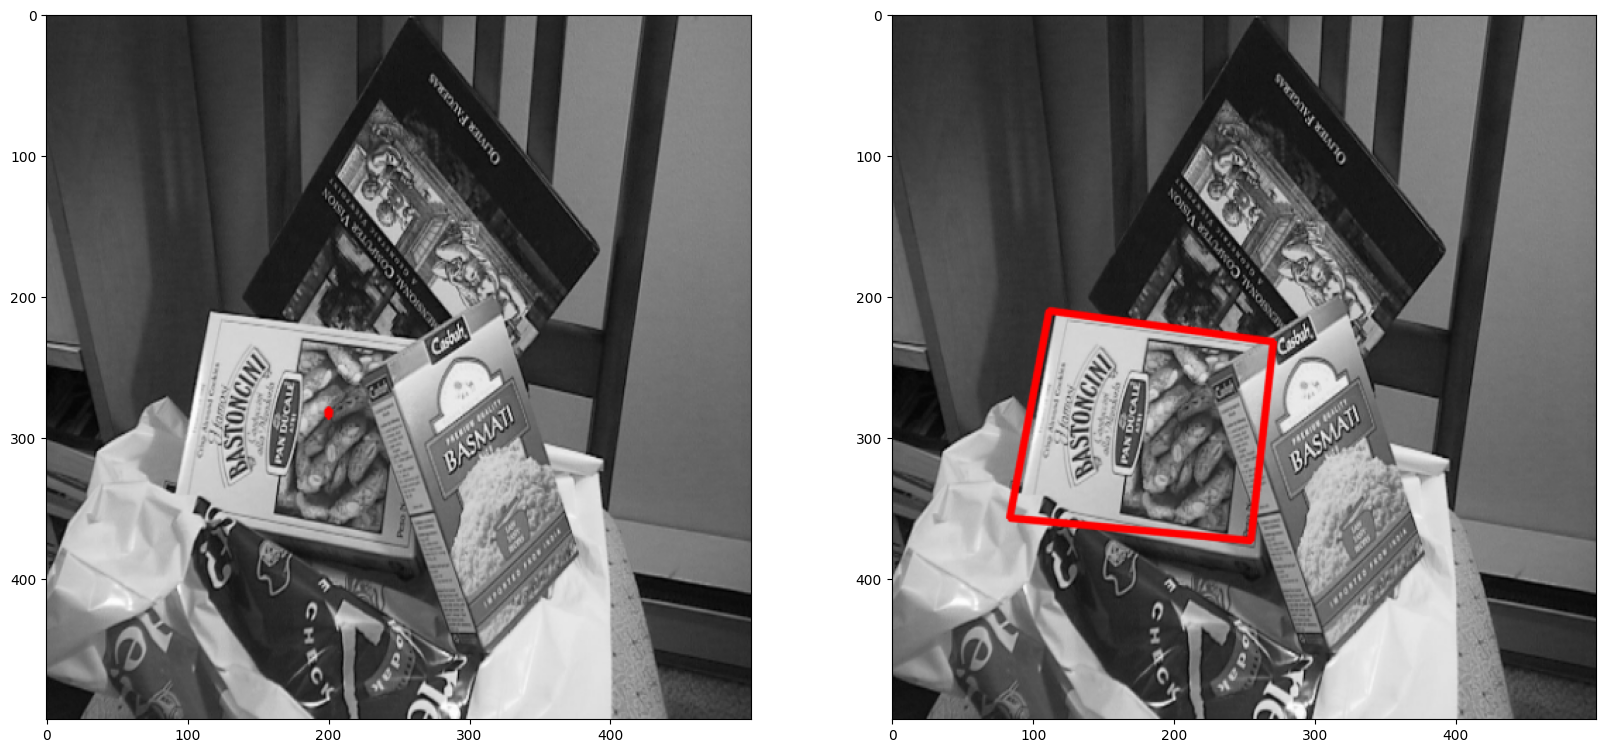

In [23]:
import cv2
import numpy as np 


# Image of the plane
IMAGE_PATH_SCENE = "./images/matches_scene.png"
IMAGE_PATH_OBJECT = "./images/matches_obj.png"

file_name_cards = IMAGE_PATH_SCENE.rsplit("/", maxsplit=1)[-1]
file_name_object = IMAGE_PATH_OBJECT.rsplit("/", maxsplit=1)[-1]

img_cards = cv2.imread(IMAGE_PATH_SCENE)
img_object = cv2.imread(IMAGE_PATH_OBJECT)

dsize = (500, 500)
dsize2 = (200, 300)

output_cards = cv2.resize(img_cards, dsize)
output_cards_r = cv2.resize(img_cards, dsize)

output_obj = cv2.resize(img_object, dsize2)

object_gray = cv2.cvtColor(output_obj, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(output_cards, cv2.COLOR_BGR2GRAY)

# Create ORB detector and descriptor
orb = cv2.ORB_create(nfeatures=1000)

# Detect keypoints and compute descriptors for both images
object_kp, object_des = orb.detectAndCompute(object_gray, None)
scene_kp, scene_des = orb.detectAndCompute(scene_gray, None)

# Create a brute-force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(object_des, scene_des)

# Apply Lowe's ratio test
ratio_thresh = 0.9
good_matches = []
for m in matches:
    if len(matches) > 1 and m.distance < ratio_thresh * matches[1].distance:
        good_matches.append(m)



src_pts = np.float32([object_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts, 0, 5.0)
H_r, mask_r = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


h, w = output_obj.shape[:2]
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, H)
scene_img = cv2.polylines(output_cards, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

h_r, w_r = output_obj.shape[:2]
pts_r = np.float32([[0, 0], [0, h_r - 1], [w_r - 1, h_r - 1], [w_r - 1, 0]]).reshape(-1, 1, 2)
dst_r = cv2.perspectiveTransform(pts_r, H_r)
scene_img_r = cv2.polylines(output_cards_r, [np.int32(dst_r)], True, 255, 3, cv2.LINE_AA)


cv2.imshow('Result', scene_img_r)
cv2.waitKey(0)

cv2.destroyAllWindows()

line_images = [scene_img,scene_img_r]
_, axs = plt.subplots(1, 2, figsize=(20,20))
axs = axs.flatten()
for img, ax in zip(line_images, axs):
    ax.imshow(img)



## Orb with brute force matcher with Lowe's ratio test with and without RANSAC for a non occluded object

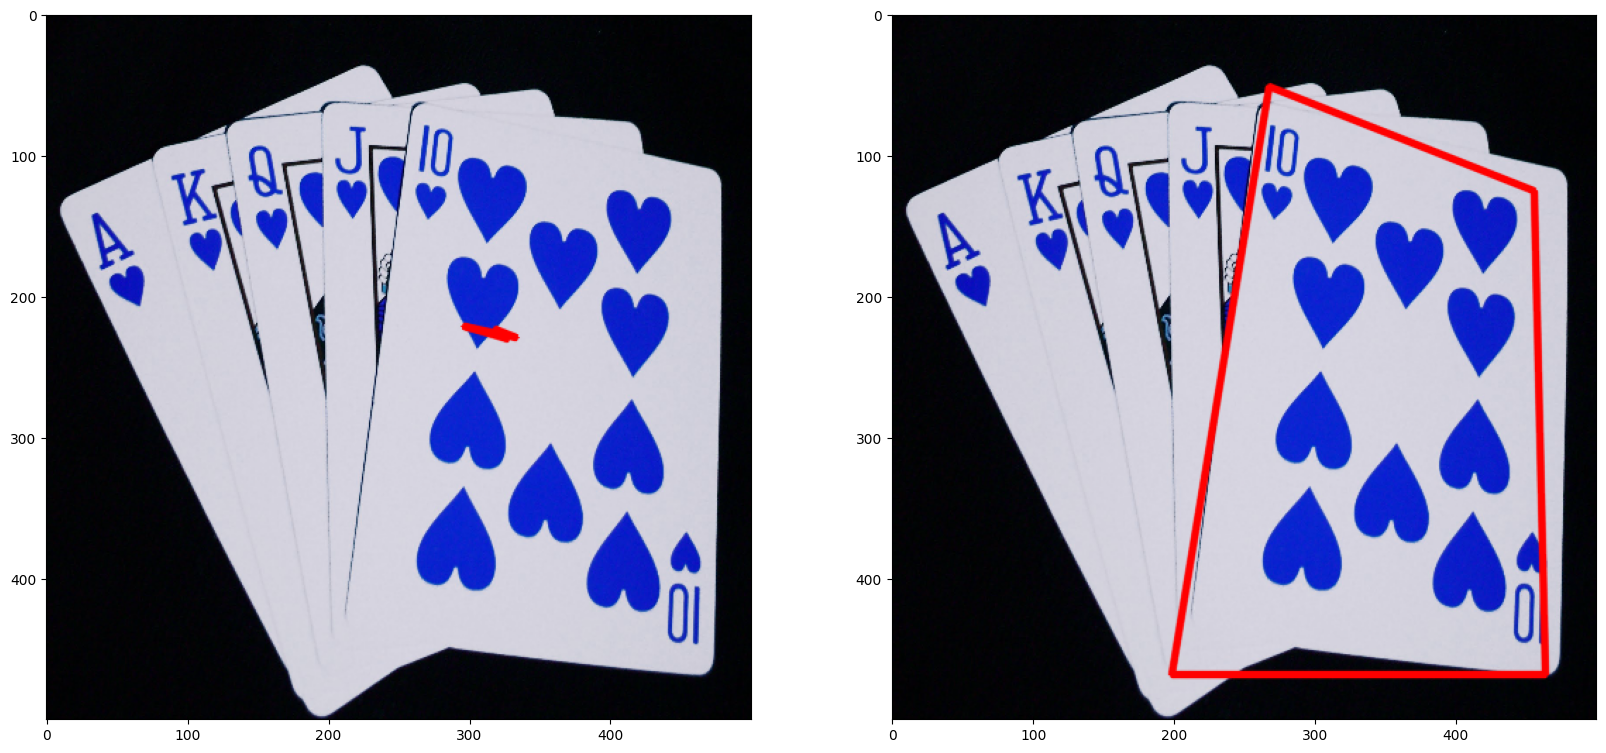

In [19]:
import cv2
import numpy as np 


IMAGE_PATH_SCENE = "./images/cards.jpg"
IMAGE_PATH_OBJECT = "./images/cards_object.png"

file_name_cards = IMAGE_PATH_SCENE.rsplit("/", maxsplit=1)[-1]
file_name_object = IMAGE_PATH_OBJECT.rsplit("/", maxsplit=1)[-1]

img_cards = cv2.imread(IMAGE_PATH_SCENE)
img_object = cv2.imread(IMAGE_PATH_OBJECT)

dsize = (500, 500)
dsize2 = (200, 300)

output_cards = cv2.resize(img_cards, dsize)
output_cards_r = cv2.resize(img_cards, dsize)

output_obj = cv2.resize(img_object, dsize2)
object_gray = cv2.cvtColor(output_obj, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(output_cards, cv2.COLOR_BGR2GRAY)

# Create ORB detector and descriptor
orb = cv2.ORB_create(nfeatures=1000)

# Detect keypoints and compute descriptors for both images
object_kp, object_des = orb.detectAndCompute(object_gray, None)
scene_kp, scene_des = orb.detectAndCompute(scene_gray, None)

# Create a brute-force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(object_des, scene_des)

# Apply Lowe's ratio test
ratio_thresh = 0.9
good_matches = []
for m in matches:
    if len(matches) > 1 and m.distance < ratio_thresh * matches[1].distance:
        good_matches.append(m)



src_pts = np.float32([object_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts, 0, 5.0)
H_r, mask_r = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


h, w = output_obj.shape[:2]
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, H)
scene_img = cv2.polylines(output_cards, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

h_r, w_r = output_obj.shape[:2]
pts_r = np.float32([[0, 0], [0, h_r - 1], [w_r - 1, h_r - 1], [w_r - 1, 0]]).reshape(-1, 1, 2)
dst_r = cv2.perspectiveTransform(pts_r, H_r)
scene_img_r = cv2.polylines(output_cards_r, [np.int32(dst_r)], True, 255, 3, cv2.LINE_AA)


cv2.imshow('Result', scene_img_r)
cv2.waitKey(0)

cv2.destroyAllWindows()


line_images = [scene_img,scene_img_r]
_, axs = plt.subplots(1, 2, figsize=(20,20))
axs = axs.flatten()
for img, ax in zip(line_images, axs):
    ax.imshow(img)



### BRISK with FLann's based matcher with Lowe's ratio test with and without RANSAC for an occluded object

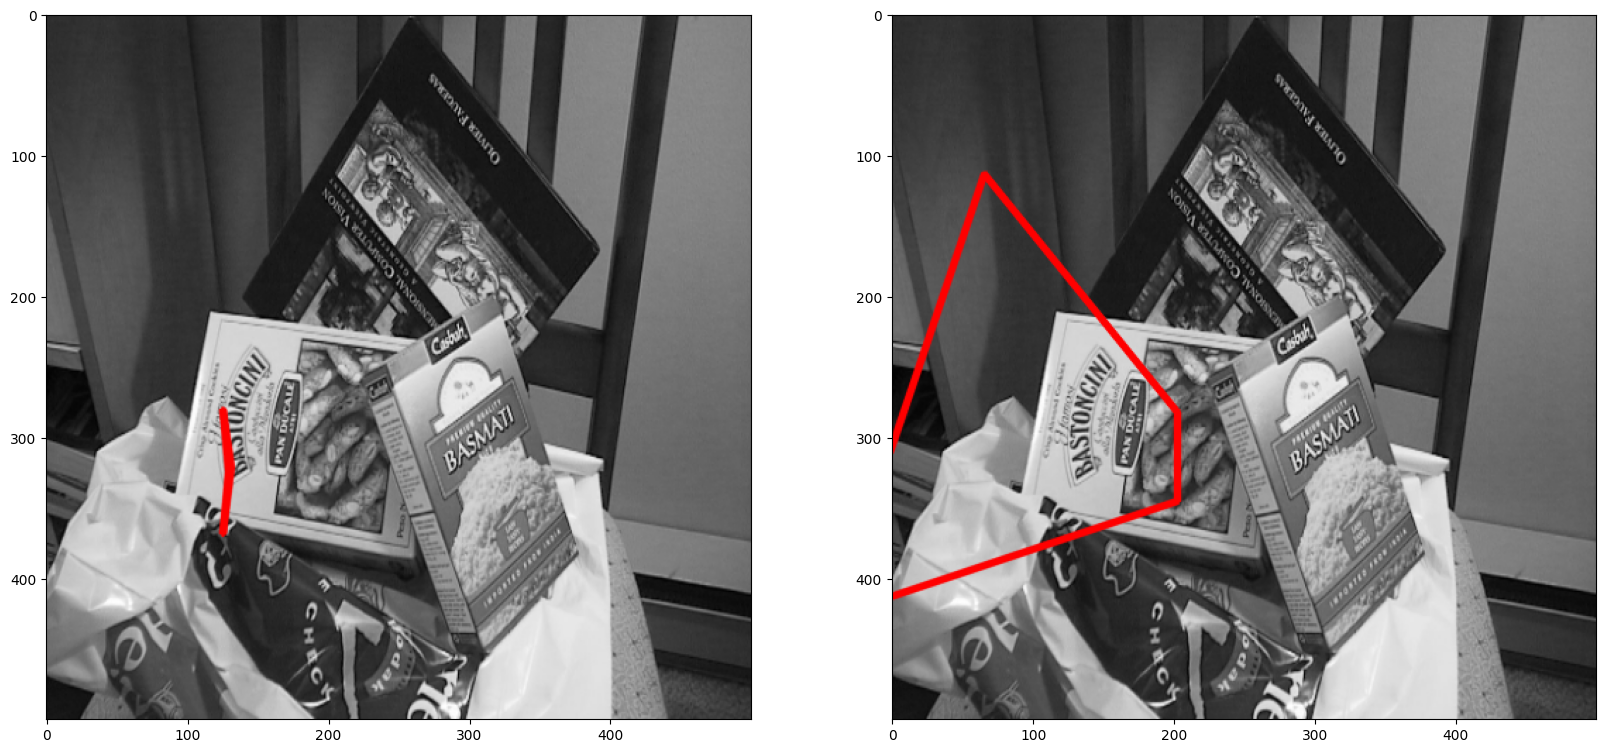

In [25]:
import cv2
import numpy as np 


# Image of the plane
IMAGE_PATH_SCENE = "./images/matches_scene.png"
IMAGE_PATH_OBJECT = "./images/matches_obj.png"

file_name_cards = IMAGE_PATH_SCENE.rsplit("/", maxsplit=1)[-1]
file_name_object = IMAGE_PATH_OBJECT.rsplit("/", maxsplit=1)[-1]

img_cards = cv2.imread(IMAGE_PATH_SCENE)
img_object = cv2.imread(IMAGE_PATH_OBJECT)

dsize = (500, 500)
dsize2 = (200, 300)

output_cards = cv2.resize(img_cards, dsize)
output_cards_r = cv2.resize(img_cards, dsize)

output_obj = cv2.resize(img_object, dsize2)
object_gray = cv2.cvtColor(output_obj, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(output_cards, cv2.COLOR_BGR2GRAY)

# Create BRISK detector and descriptor
brisk_detector = cv2.BRISK_create()

# Detect keypoints and compute descriptors for both images
object_kp, object_des = orb.detectAndCompute(object_gray, None)
scene_kp, scene_des = orb.detectAndCompute(scene_gray, None)

# Create a brute-force matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(object_des, scene_des)

# Apply Lowe's ratio test
ratio_thresh = 0.9
good_matches = []
for m in matches:
    if len(matches) > 1 and m.distance < ratio_thresh * matches[1].distance:
        good_matches.append(m)



src_pts = np.float32([object_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts, 0, 5.0)
H_r, mask_r = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


h, w = output_obj.shape[:2]
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, H)
scene_img = cv2.polylines(output_cards, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

h_r, w_r = output_obj.shape[:2]
pts_r = np.float32([[0, 0], [0, h_r - 1], [w_r - 1, h_r - 1], [w_r - 1, 0]]).reshape(-1, 1, 2)
dst_r = cv2.perspectiveTransform(pts_r, H_r)
scene_img_r = cv2.polylines(output_cards_r, [np.int32(dst_r)], True, 255, 3, cv2.LINE_AA)


line_images = [scene_img,scene_img_r]
_, axs = plt.subplots(1, 2, figsize=(20,20))
axs = axs.flatten()
for img, ax in zip(line_images, axs):
    ax.imshow(img)



### BRISK with FLann's based matcher with Lowe's ratio test with and without RANSAC for a non occluded object

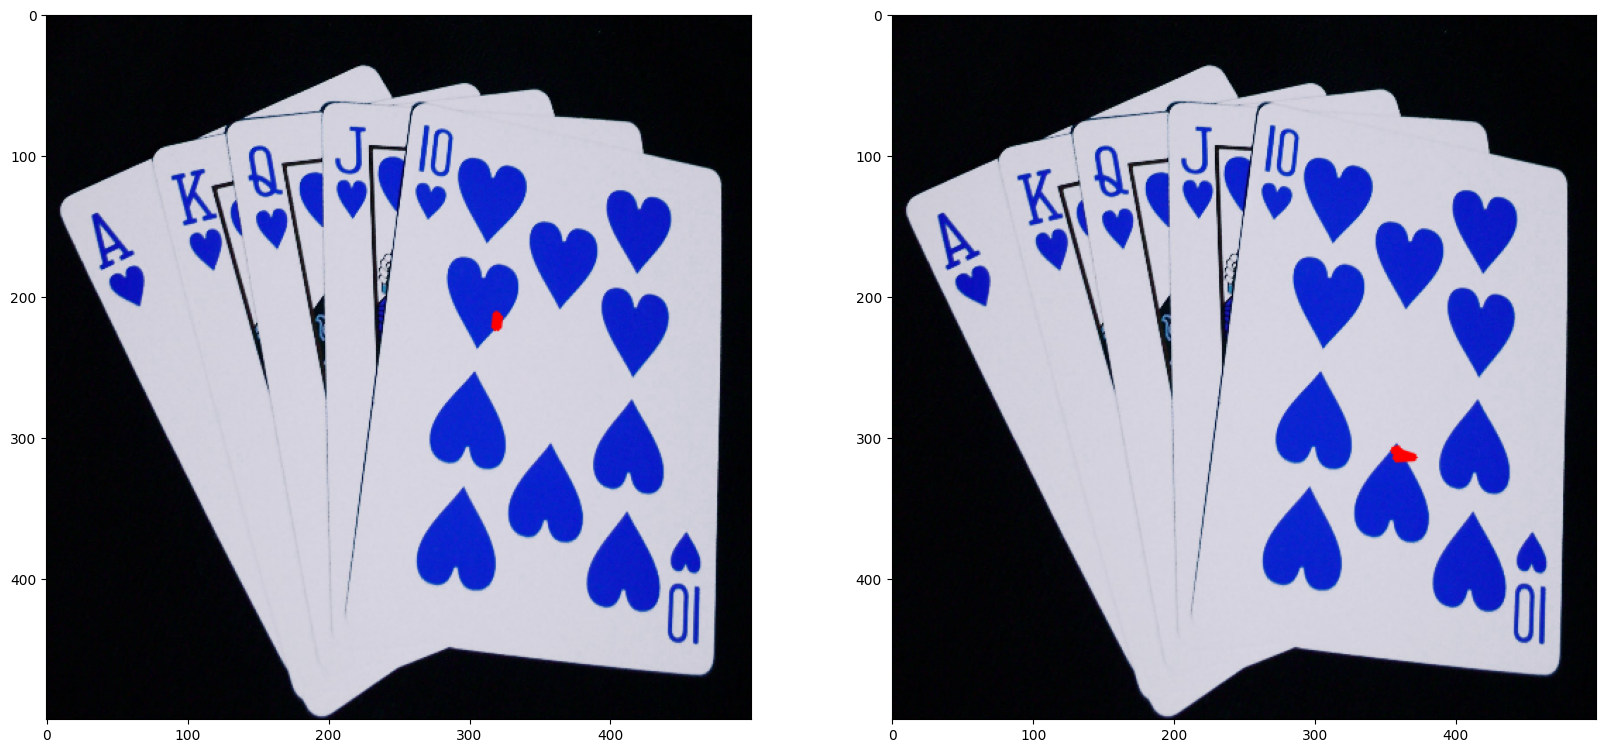

In [20]:
import cv2
import numpy as np 

IMAGE_PATH_SCENE = "./images/cards.jpg"
IMAGE_PATH_OBJECT = "./images/cards_object.png"

file_name_cards = IMAGE_PATH_SCENE.rsplit("/", maxsplit=1)[-1]
file_name_object = IMAGE_PATH_OBJECT.rsplit("/", maxsplit=1)[-1]

img_cards = cv2.imread(IMAGE_PATH_SCENE)
img_object = cv2.imread(IMAGE_PATH_OBJECT)

dsize = (500, 500)
dsize2 = (200, 300)

output_cards = cv2.resize(img_cards, dsize)
output_cards_r = cv2.resize(img_cards, dsize)

output_obj = cv2.resize(img_object, dsize2)

object_gray = cv2.cvtColor(output_obj, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(output_cards, cv2.COLOR_BGR2GRAY)

# Create BRISK detector and descriptor
brisk_detector = cv2.BRISK_create()

# Detect keypoints and compute descriptors for both images
object_kp, object_des = orb.detectAndCompute(object_gray, None)
scene_kp, scene_des = orb.detectAndCompute(scene_gray, None)

# Create a brute-force matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(object_des, scene_des)

# Apply Lowe's ratio test
ratio_thresh = 0.9
good_matches = []
for m in matches:
    if len(matches) > 1 and m.distance < ratio_thresh * matches[1].distance:
        good_matches.append(m)



src_pts = np.float32([object_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts, 0, 5.0)
H_r, mask_r = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)


h, w = output_obj.shape[:2]
pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, H)
scene_img = cv2.polylines(output_cards, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

h_r, w_r = output_obj.shape[:2]
pts_r = np.float32([[0, 0], [0, h_r - 1], [w_r - 1, h_r - 1], [w_r - 1, 0]]).reshape(-1, 1, 2)
dst_r = cv2.perspectiveTransform(pts_r, H_r)
scene_img_r = cv2.polylines(output_cards_r, [np.int32(dst_r)], True, 255, 3, cv2.LINE_AA)

cv2.imshow('Result', scene_img_r)
cv2.waitKey(0)

cv2.destroyAllWindows()

line_images = [scene_img,scene_img_r]
_, axs = plt.subplots(1, 2, figsize=(20,20))
axs = axs.flatten()
for img, ax in zip(line_images, axs):
    ax.imshow(img)

